In [1]:
#import dependencies
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [2]:
# Load Data
df = yf.download('SBIN.NS', start='2012-01-01', end='2024-12-17').dropna()

[*********************100%***********************]  1 of 1 completed


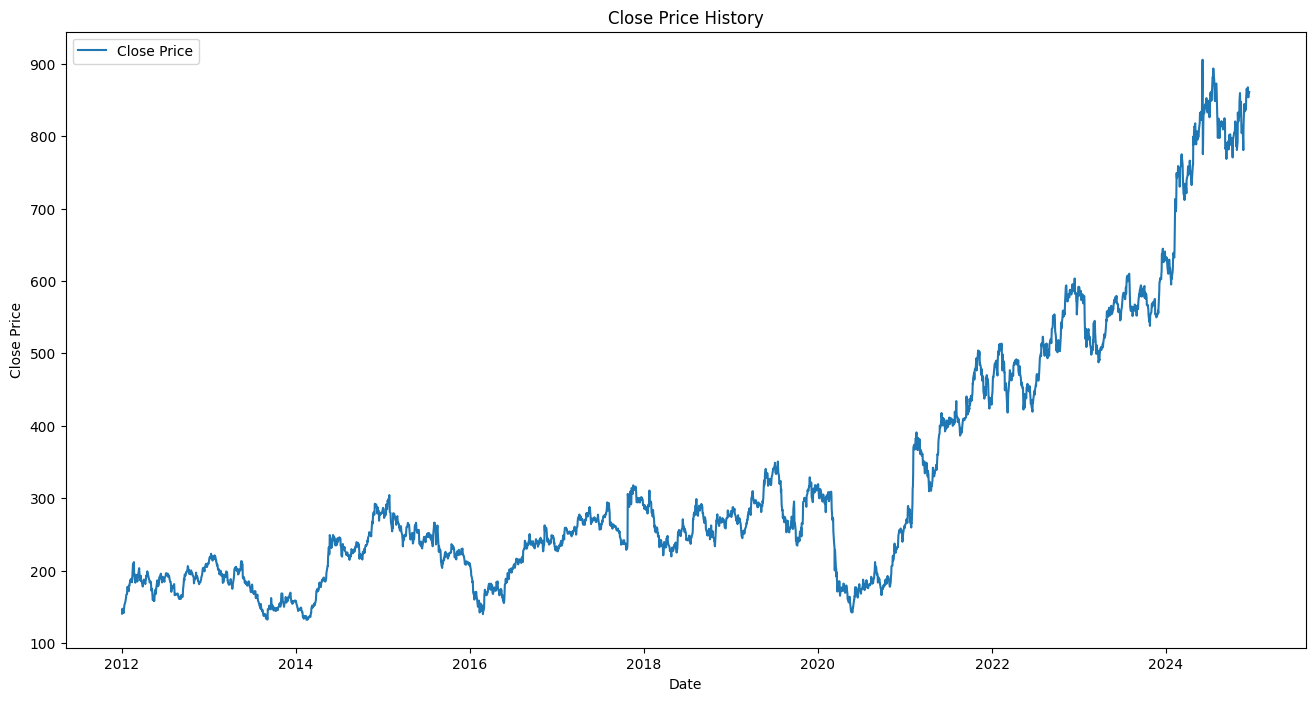

In [3]:
# Visualize Data
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price')
plt.title('Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [4]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
data = df[['Close']]
scaled_data = scaler.fit_transform(data)


In [5]:
# Split Data
train_ratio = 0.8
train_size = math.ceil(len(scaled_data) * train_ratio)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]

In [6]:
# Create Sequences
def create_sequences(data, lookback=60):
    x, y = [], []
    for i in range(lookback, len(data)):
        x.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_data)
x_test, y_test = create_sequences(test_data)

In [7]:
# Reshape Data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [8]:
# Build Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Train Model
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=10, epochs=10, callbacks=[early_stop])


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 0.0024
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 2.5212e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 1.9618e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 1.6904e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 1.4192e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - loss: 1.2462e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 1.2032e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - loss: 9.8549e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 9.5501e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 8.9264e-05


In [10]:
# Make Predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [11]:
# Visualize Predictions
valid = data[train_size:].copy()
valid['Predictions'] = predictions


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R2 Score: {r2}")


MAE: 636.6989597071417
MAPE: 104836.63745975307
R2 Score: -15141753.990174618


In [14]:
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()


In [15]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(scaled_data):
    print("Train indices:", train_idx, "Test indices:", test_idx)


Train indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242

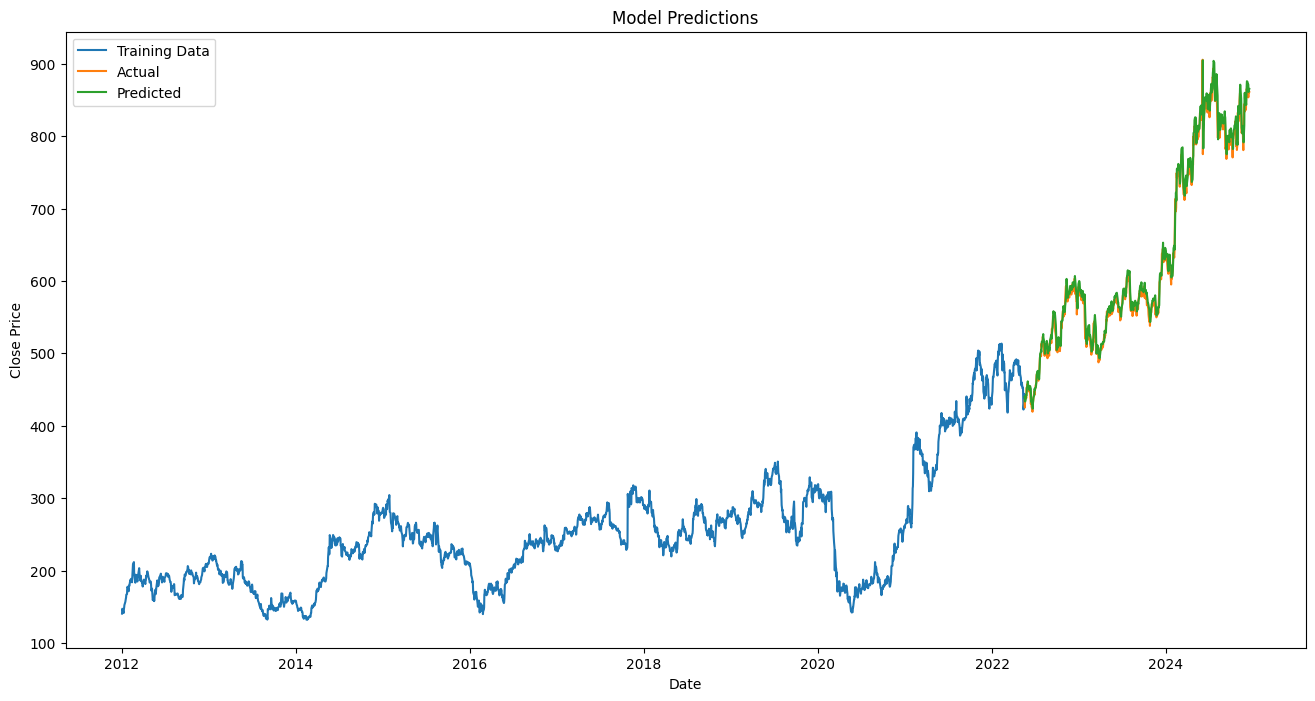

In [16]:
# Visualize Predictions
valid = data[train_size:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.plot(data[:train_size], label='Training Data')
plt.plot(valid[['Close', 'Predictions']], label=['Actual', 'Predicted'])
plt.title('Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()